# E13 : 주식 예측에 도전해 보자

`23 FEB 2021 `

-----------------


목차
>1. 시계열 데이터 준비
>2. 각종 전처리 수행
>3. 시계열 안정성 분석
>4. 학습, 테스트 데이터셋 생성
>5. 적정한 ARIMA 모수 찾기
>6. ARIMA 모델 훈련과 테스트
>7. 다른 주식 종목 예측해보기



ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세이며, 다음의 그림과 같이 Yahoo Finance에서 아래 그림을 따라 하시면 다운로드할 수 있습니다.


우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다. 이를 위해서 "samsung"을 검색하시고, "Historical Data" 탭에서 "Time Period"를 "Max"로 선택, "Apply" 버튼을 눌러 과거 삼성전자가 상장한 시점부터 가장 최근까지의 자료를 조회합니다. 그리고 "Download"를 클릭하면 데이터를 다운로드를 할 수 있습니다. 다운로드가 완료되었다면 대략 다음과 같이 작업 디렉토리로 파일을 옮겨 주세요. 실습환경에 따라 원본(source)과 사본(destination) 경로는 달라질 수 있습니다.




https://finance.yahoo.com/quote/005930.KS/history?period1=946944000&period2=1614643200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true


$ mv ~/Downloads/005930.KS.csv ~/aiffel/stock_prediction/data


이후 순서는 다음과 같습니다. 필요한 내용은 이미 앞에서 다 다루었기 때문에 이후 과정은 여러분들이 직접 수행해 보시기를 바랍니다.


## 필요한 라이브러리 import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os



## STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. 

(주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [5]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


In [7]:
ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64


## STEP 2 : 각종 전처리 수행
- 결측치 처리

- 로그 변환

In [21]:
# 결측치 확인
ts[ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [22]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

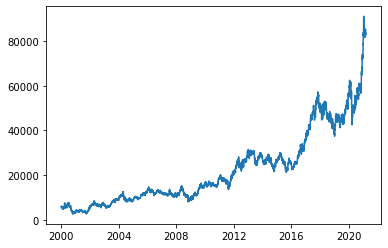

In [23]:
plt.plot(ts)

In [24]:
# 로그 변환 시도 
ts_log = np.log(ts)

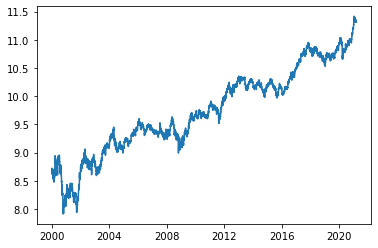

In [25]:
plt.plot(ts_log)


## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [28]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [29]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

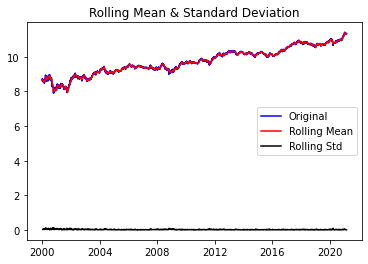

Results of Dickey-Fuller Test:
Test Statistic                   -0.304128
p-value                           0.924918
#Lags Used                        4.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


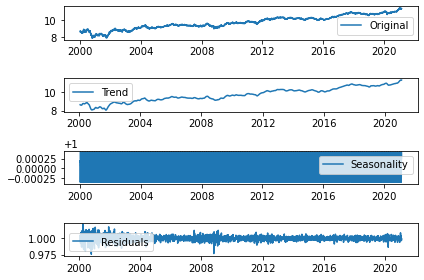

In [30]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [31]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.761317e+01
p-value                        3.870691e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.255000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

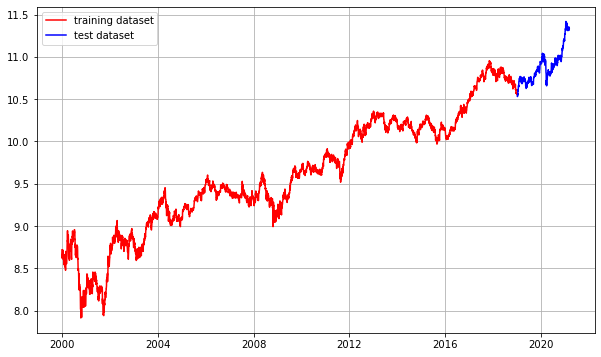

In [32]:
# 9:1
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label="training dataset")
plt.plot(test_data, c='b', label="test dataset")
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기

차분 안정성 확인 -> d 구하기

p : 자기회귀 모형(AR)의 시차를 의미

q : 이동 평균 모형(MA)의 시차를 의미

d : 차분 횟수를 의미

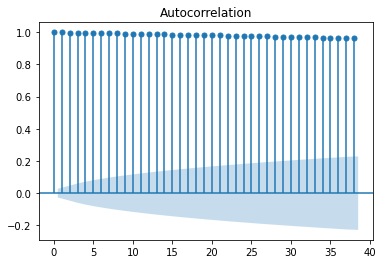

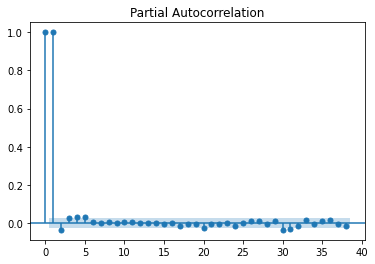

In [34]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.104183
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


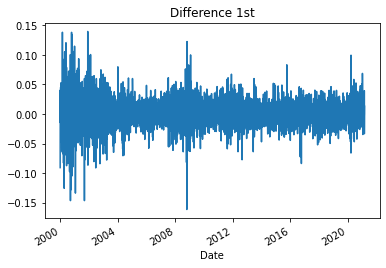

In [35]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.838292
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5283.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


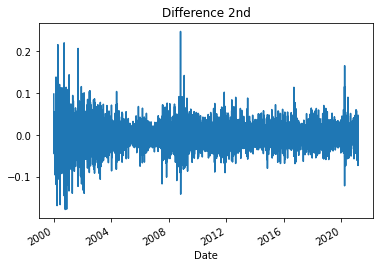

In [36]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                  -40.104183
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.838292
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5283.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


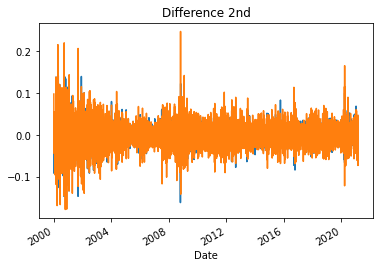

In [37]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련

- 모델 테스트 및 플로팅

- 최종 예측 모델 정확도 측정(MAPE)

In [38]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4786
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11280.268
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 02 Mar 2021   AIC                         -22554.536
Time:                        22:46:18   BIC                         -22535.116
Sample:                             1   HQIC                        -22547.714
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.112      0.266      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

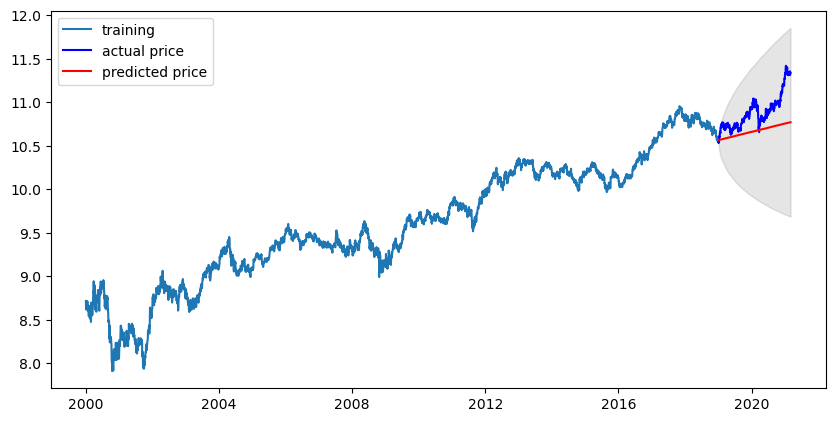

In [39]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  216722178.6060887
MAE:  11344.904774659126
RMSE:  14721.486969939167
MAPE: 18.72%


## STEP 7 : 다른 주식 종목 예측해 보기

아마 코로나로 인한 주식 장의 변동이 매우 컸을 것이다. 특히 한국 주식 시장은 더 큰 타격을 많이 입어서 예측의 정확도가 해외장보다 더 신뢰도가 떨어질 것 같다는 생각이 들어서 uber 주식 데이터를 가지고 예측을 진행해보겠습니다.



In [41]:
mv ~/Downloads/UBER.csv ~/aiffel/stock_prediction/data

In [45]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/UBER.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-23,53.500000,56.369999,51.889999,56.000000,56.000000,23947500
2021-02-24,54.950001,55.150002,53.660000,53.910000,53.910000,24627000
2021-02-25,54.580002,54.599998,50.860001,51.450001,51.450001,27049100
2021-02-26,52.070000,52.750000,50.610001,51.750000,51.750000,16349800
2021-03-01,53.669998,54.759998,53.299999,54.400002,54.400002,18451200


In [46]:
ts.head()

Date
2019-05-10    41.570000
2019-05-13    37.099998
2019-05-14    39.959999
2019-05-15    41.290001
2019-05-16    43.000000
Name: Close, dtype: float64

In [47]:
ts.tail()

Date
2021-02-23    56.000000
2021-02-24    53.910000
2021-02-25    51.450001
2021-02-26    51.750000
2021-03-01    54.400002
Name: Close, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -1.530255
p-value                          0.518495
#Lags Used                      12.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

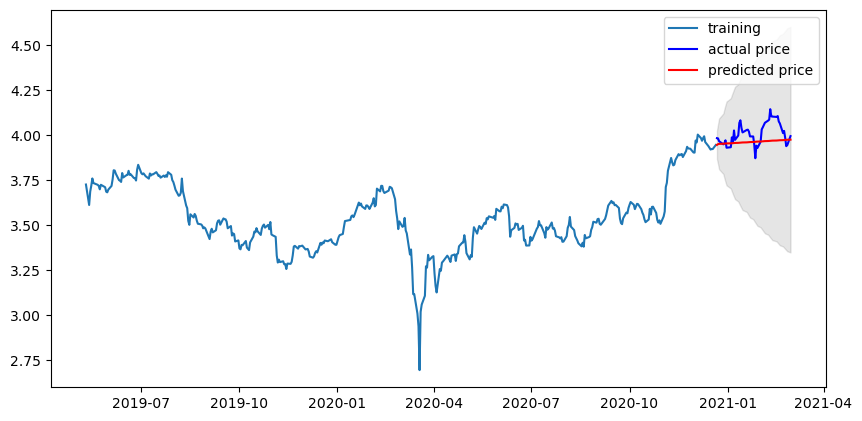

MSE:  17.569733453480094
MAE:  3.3257176220528177
RMSE:  4.191626588030009
MAPE: 5.79%


In [48]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

ts_log = np.log(ts)

augmented_dickey_fuller_test(ts_log)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

model = ARIMA(train_data, order=(1,1,2))
fit_model = model.fit(disp=-1)

fc, se, conf = fit_model.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

# 회고

### 어려움

- 예시 코드가 나와있어서 수월하다고 느꼈지만 아직 완전히 이해를 한 것 같지는 않다. 주식에 관심이 많아서 이번노드를 더 다양한 방법으로 진행해보고 싶었는데 개인적인 사정으로 기본정도만 수행한것 같아 아쉽다. NLP로 가기로 마음먹은 후에 관련 노드들을 처음부터 정리해보고 있는데 이번노드는 더 제대로 해서 진행해볼 것이다. 

- 주식 시장이라는게 예측이 정말 어렵고 앞으로도 쉽지 않을 것으로 예상된다. 물론 기계가 사고 파는것에 영향을 많이 받지만 현재는 코로나라는 특수한 상황에 처해 있기도 하고 한국 시장은 내외부의 영향에도 변동의 폭이 매우 커서 더 어려운것 같다. 해외 주식장과의 차이? 같은 부분도 같이 분석해봐야겠다. 재미있을 것 같다.


- 코로나 시작일때 부터 현재까지의 기간만 뽑아서도 진행을 해봐야겠다.(변동이 매우 크므로)

- 다른 모델로도 예측하는 방법도 여러가지 적용해서 진행해볼 예정

- 노드 자체는 수학적인 내용이 많은데 시계열 데이터가 가고싶은 분야와 매우 관련도가 높아서 이번기회에 제대로 이해하고 정리해서 내것으로 꼭 체득할것이다. 

- p,d,q의 값을 찾는 과정 다시 학습 필요


## 참고

- 논문 


[ARIMA 모형과 텍스트 마이닝을 이용한 주가 등락 예측 = Stock Fluctuation Prediction using the ARIMA Model and Text Mining](http://www.riss.kr/search/detail/DetailView.do?p_mat_type=be54d9b8bc7cdb09&control_no=594269311e2ce4acffe0bdc3ef48d419&outLink=K)